### Goal: Explore how to modify pseudo pop logic to include multiple sessions

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils

from utils.session_data import SessionData
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.rule_condition_block_splitter import RuleConditionBlockSplitter
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter
from trial_splitters.dummy_pseudo_splitter import DummyPseudoSplitter
from trial_splitters.condition_kfold_block_splitter import ConditionKFoldBlockSplitter

from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate






species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

### Compare pre-generated Pseudo Decoding results to single session decoding

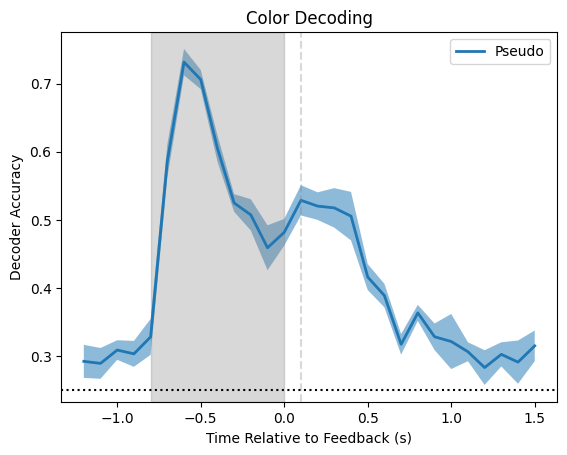

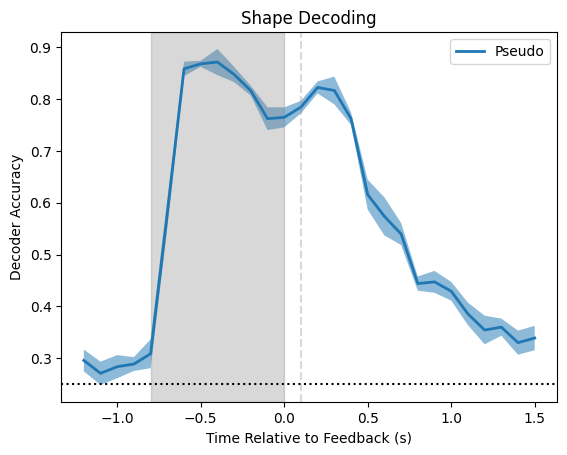

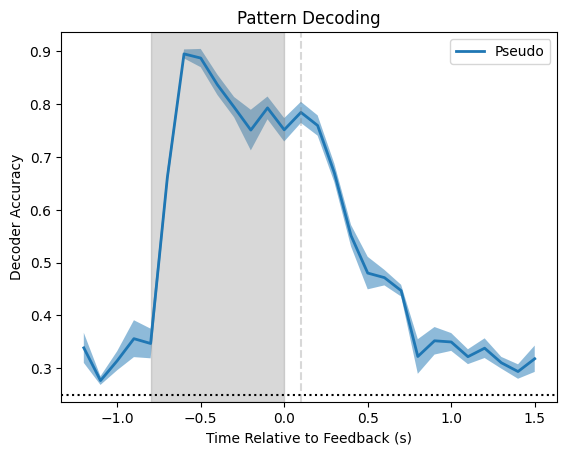

In [2]:
for feature_dim in feature_dims: 
    fig, ax = plt.subplots()
    original_train, original_test, _, _, _ = io_utils.load_model_outputs(
        feature_dim, 
        "1300_fb_1500",
        "random_split",
    )

    pseudo_train = np.load(f"/data/patrick_scratch/pseudo/{feature_dim}_train_accs.npy")
    pseudo_test = np.load(f"/data/patrick_scratch/pseudo/{feature_dim}_test_accs.npy")
    pseudo_shuffle = np.load(f"/data/patrick_scratch/pseudo/{feature_dim}_shuffled_accs.npy")

    # visualization_utils.visualize_accuracy_across_time_bins(
    #     original_train,
    #     1.3, 1.5, 0.1,
    #     ax,
    #     label=f"2018-08-02 Train",
    #     right_align=True, 
    # )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     original_test,
    #     1.3, 1.5, 0.1,
    #     ax,
    #     label=f"2018-08-02 session",
    #     right_align=True, 
    # )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     pseudo_train,
    #     1.3, 1.5, 0.1,
    #     ax,
    #     label=f"Pseudo Train",
    #     right_align=True, 
    # )
    visualization_utils.visualize_accuracy_across_time_bins(
        pseudo_test,
        1.3, 1.5, 0.1,
        ax,
        label=f"Pseudo",
        right_align=True, 
    )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     pseudo_shuffle,
    #     1.3, 1.5, 0.1,
    #     ax,
    #     label=f"Pseudo Shuffled",
    #     right_align=True, 
    # )
    ax.legend()
    ax.set_title(f"{feature_dim} Decoding")
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")


### Replot but all in the same plot

Text(0, 0.5, 'Decoder Accuracy')

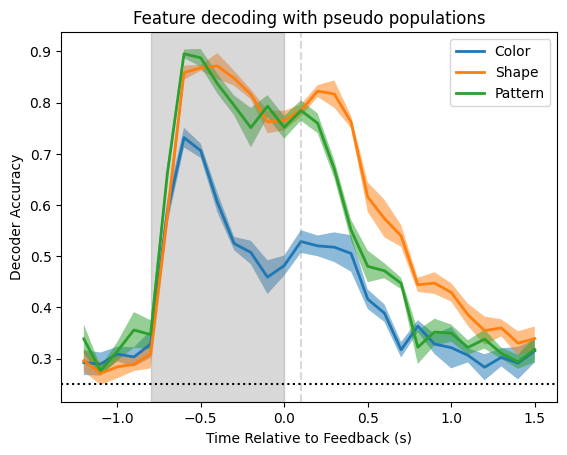

In [4]:
fig, ax = plt.subplots()
for feature_dim in feature_dims: 
    pseudo_test = np.load(f"/data/patrick_scratch/pseudo/{feature_dim}_test_accs.npy")
    visualization_utils.visualize_accuracy_across_time_bins(
        pseudo_test,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim}",
        right_align=True, 
    )
ax.legend()
ax.set_title(f"Feature decoding with pseudo populations")
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

### Check rule dim pseudo

Text(0, 0.5, 'Decoder Accuracy')

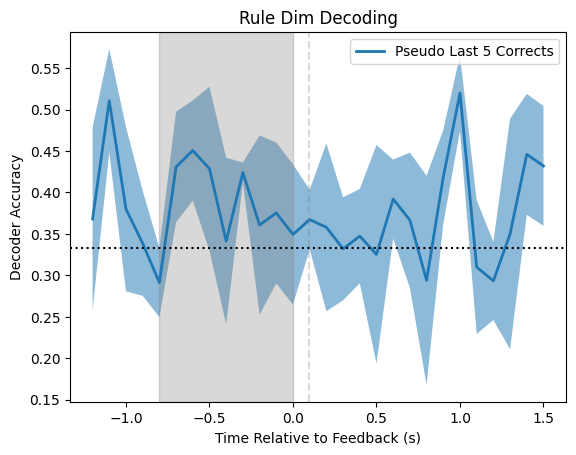

In [7]:
fig, ax = plt.subplots()

# pseudo_train = np.load(f"/data/patrick_scratch/pseudo/rule_dim_train_accs.npy")
pseudo_test = np.load(f"/data/patrick_scratch/pseudo/rule_dim_test_accs.npy")
pseudo_not_figured = np.load(f"/data/patrick_scratch/pseudo/rule_dim_not_figured_out_test_accs.npy")
# pseudo_shuffle = np.load(f"/data/patrick_scratch/pseudo/rule_dim_shuffled_accs.npy")

# visualization_utils.visualize_accuracy_across_time_bins(
#     pseudo_train,
#     1.3, 1.5, 0.1,
#     ax,
#     label=f"Pseudo Train",
#     right_align=True, 
# )
visualization_utils.visualize_accuracy_across_time_bins(
    pseudo_test,
    1.3, 1.5, 0.1,
    ax,
    label=f"Pseudo Last 5 Corrects",
    right_align=True, 
)
# visualization_utils.visualize_accuracy_across_time_bins(
#     pseudo_not_figured,
#     1.3, 1.5, 0.1,
#     ax,
#     label=f"Pseudo Not Figured",
#     right_align=True, 
# )
# visualization_utils.visualize_accuracy_across_time_bins(
#     pseudo_shuffle,
#     1.3, 1.5, 0.1,
#     ax,
#     label=f"Pseudo Shuffled",
#     right_align=True, 
# )
ax.legend()
ax.set_title(f"Rule Dim Decoding")
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.333, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

In [2]:
rule_to_dim = {
    'CIRCLE': 'SHAPE', 
    'SQUARE': 'SHAPE', 
    'STAR': 'SHAPE', 
    'TRIANGLE': 'SHAPE', 
    'CYAN': 'COLOR', 
    'GREEN': 'COLOR', 
    'MAGENTA': 'COLOR', 
    'YELLOW': 'COLOR', 
    'ESCHER': 'PATTERN', 
    'POLKADOT': 'PATTERN', 
    'RIPPLE': 'PATTERN', 
    'SWIRL': 'PATTERN'
}

sess_name = 201807250001
behavior_path = f"/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
beh = pd.read_csv(behavior_path)
valid_beh = beh[(beh.Response.isin(["Correct", "Incorrect"])) & (beh.BlockNumber >= 2)]  
valid_beh["RuleDim"] = valid_beh.apply(lambda x: rule_to_dim[x.CurrentRule], axis=1)

/tmp/ipykernel_77559/476465942.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_beh["RuleDim"] = valid_beh.apply(lambda x: rule_to_dim[x.CurrentRule], axis=1)


In [5]:
valid_beh

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,Item1Shape,Item1Color,Item1Pattern,Item2Shape,Item2Color,Item2Pattern,Item3Shape,Item3Color,Item3Pattern,RuleDim
36,36,2,0,NaN,2467,Incorrect,3.0,4,CYAN,SQUARE,...,STAR,MAGENTA,SWIRL,TRIANGLE,YELLOW,ESCHER,SQUARE,GREEN,RIPPLE,COLOR
37,37,2,1,NaN,2434,Incorrect,3.0,4,CYAN,SQUARE,...,STAR,MAGENTA,RIPPLE,CIRCLE,YELLOW,POLKADOT,SQUARE,GREEN,ESCHER,COLOR
38,38,2,2,NaN,2330,Incorrect,1.0,4,CYAN,SQUARE,...,CIRCLE,MAGENTA,SWIRL,SQUARE,YELLOW,RIPPLE,STAR,GREEN,ESCHER,COLOR
39,39,2,3,NaN,2332,Correct,0.0,4,CYAN,SQUARE,...,CIRCLE,MAGENTA,ESCHER,SQUARE,YELLOW,RIPPLE,STAR,GREEN,SWIRL,COLOR
40,40,2,4,NaN,2754,Correct,0.0,4,CYAN,SQUARE,...,CIRCLE,MAGENTA,RIPPLE,STAR,YELLOW,ESCHER,TRIANGLE,GREEN,SWIRL,COLOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,593,16,16,NaN,1557,Correct,0.0,10,STAR,ESCHER,...,TRIANGLE,GREEN,RIPPLE,CIRCLE,CYAN,ESCHER,SQUARE,MAGENTA,POLKADOT,SHAPE
594,594,16,17,NaN,1697,Correct,0.0,10,STAR,ESCHER,...,TRIANGLE,YELLOW,POLKADOT,CIRCLE,MAGENTA,ESCHER,SQUARE,CYAN,RIPPLE,SHAPE
595,595,16,18,NaN,1281,Incorrect,3.0,10,STAR,ESCHER,...,TRIANGLE,YELLOW,RIPPLE,CIRCLE,MAGENTA,ESCHER,SQUARE,GREEN,POLKADOT,SHAPE
596,596,16,19,NaN,1511,Incorrect,3.0,10,STAR,ESCHER,...,TRIANGLE,CYAN,POLKADOT,CIRCLE,MAGENTA,SWIRL,SQUARE,GREEN,ESCHER,SHAPE
